In [186]:
import numpy as np
import pandas as pd

#EDA and visualization imports:
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

#pre-processing imports:
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from spellchecker import SpellChecker
from wordcloud import WordCloud

#modelling imports:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#evaluation imports:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

#global parameters
additional  = ['retweet', 've', 'RT']
all_stop = (stopwords.words('english'), additional)

In [187]:
#import and read csv's into Jupyter:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Exploratory Data Analysis of datasets

In [188]:
#get an overview of the training data to see if there is missing data etc:
profile_train = ProfileReport(train, title='Pandas train report')
profile_test = ProfileReport(test, title='Pandas test report')

In [189]:
profile_train

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [190]:
profile_test

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\JeanSwiegers\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


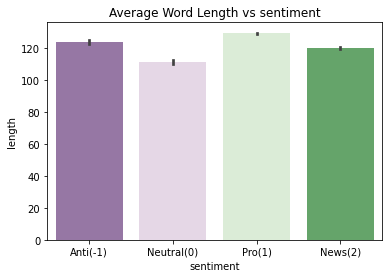

In [191]:
#Average word length vs sentiment
train['length'] = train['message'].apply(len)
fig1 = sns.barplot('sentiment','length', data=train, palette='PRGn')
plt.title('Average Word Length vs sentiment')
plt.xticks(ticks=[0,1,2,3], labels=['Anti(-1)','Neutral(0)','Pro(1)','News(2)'])
plot = fig1.get_figure()

Interesting that the average word length for people pro climate change is longer. probably cause by imbalance of classes.

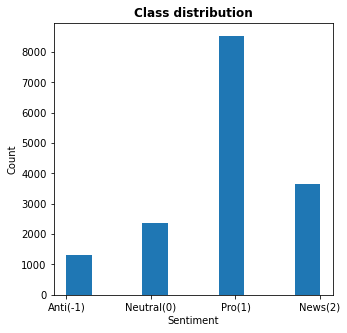

In [192]:
#take a look at class imbalance
fig, ax = plt.subplots(figsize=(5, 5))
plt.hist(train.sentiment)
plt.title('Class distribution',fontweight ="bold")
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[-1,0,1,2], labels=['Anti(-1)','Neutral(0)','Pro(1)','News(2)'])
plt.show()

As suspected, the classes are not balanced at all. I will be using TfidfTransformer() to balance classes in modelling

## Pre-processing of Twitter data

In [193]:
#create a nested function to process tweets in train and test datasets
def tweet_processing(tweet):
      
#     cleaned_tweet = clean(tweet)
    #Function to take every tweet and generate a list of words (hastags and other punctuations removed)
    def clean_tweet(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = clean_tweet(tweet)
    
    #Function to take every tweet and remove stopwords and symbols
    def clean_stopwords_symbols(tweet):
        tweet_list = [ele for ele in tweet.split()]
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$|^RT[\s]+|https?:\/\/.*[\r\n]*', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word not in all_stop]
        return clean_mess
    no_punc_tweet = clean_stopwords_symbols(new_tweet)
    
    #Function to lemmatize the words in each tweet
    def lemma(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return normalized_tweet
    
    return lemma(no_punc_tweet)

In [194]:
#define a function to easily plot tweet sentiments top words:
def plot_word_cloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24, 16), title=None, title_size=40, image_color=False):
    wordcloud = WordCloud(background_color='white', max_words = max_words, max_font_size=max_font_size, random_state=42, width=800, height=400, mask=mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear');
        plt.title(title, fontdict={'size': title_size, 'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'verticalalignment': 'bottom'})
    plt.axis=('off')
    plt.tight_layout()

Create word clouds with the created function:

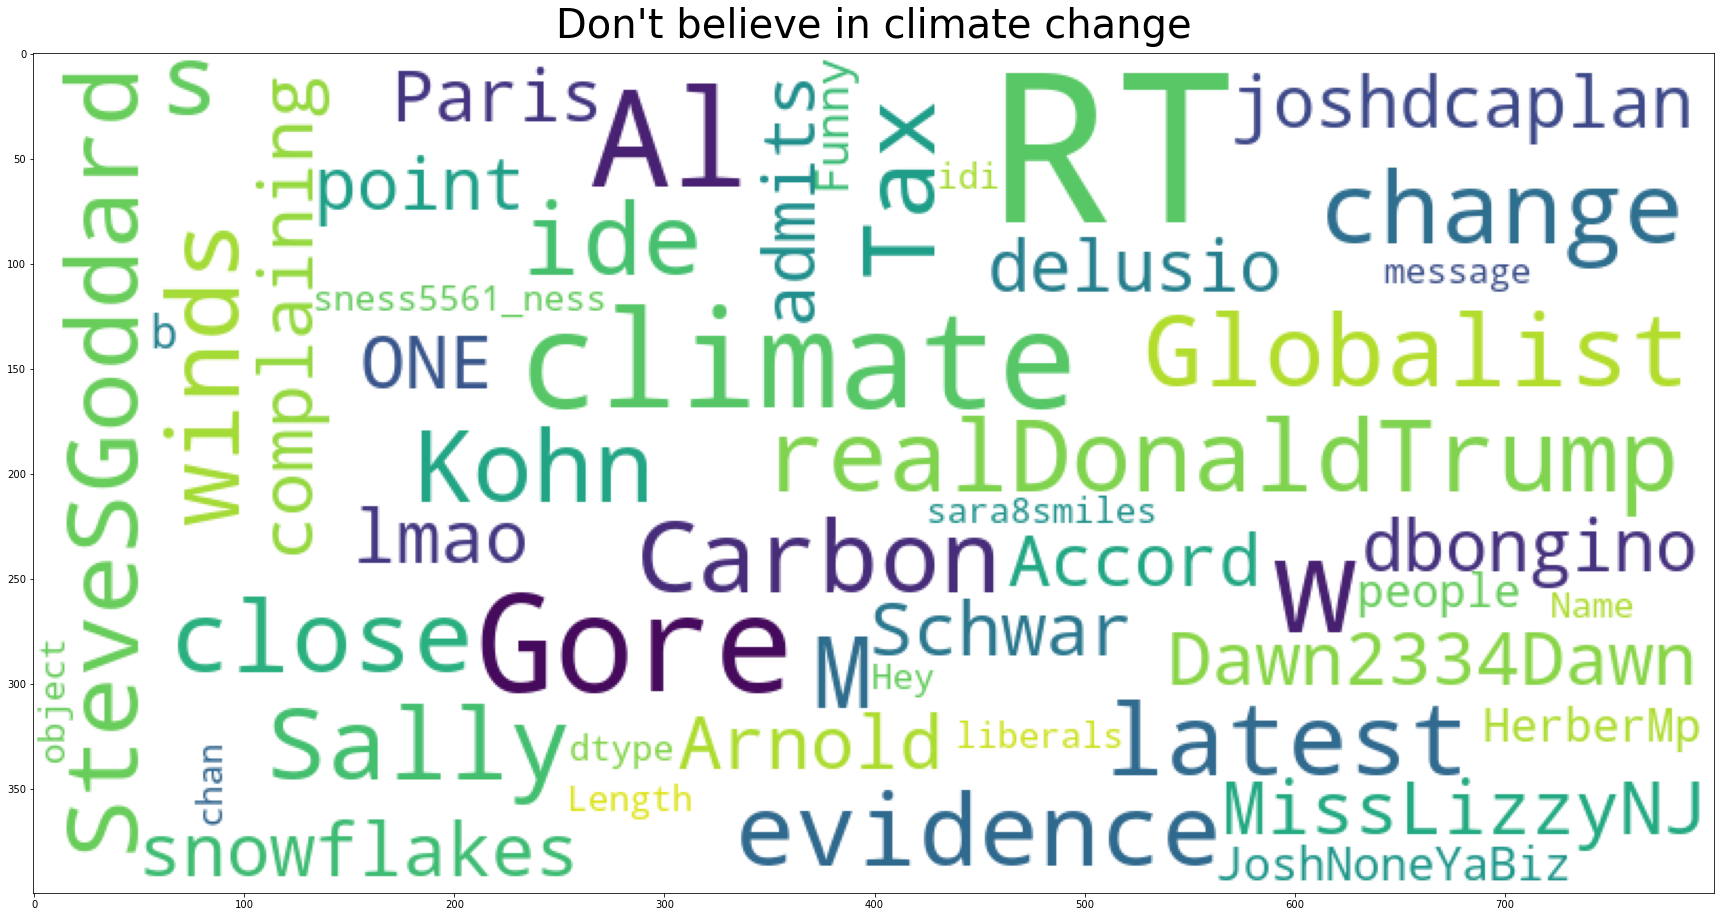

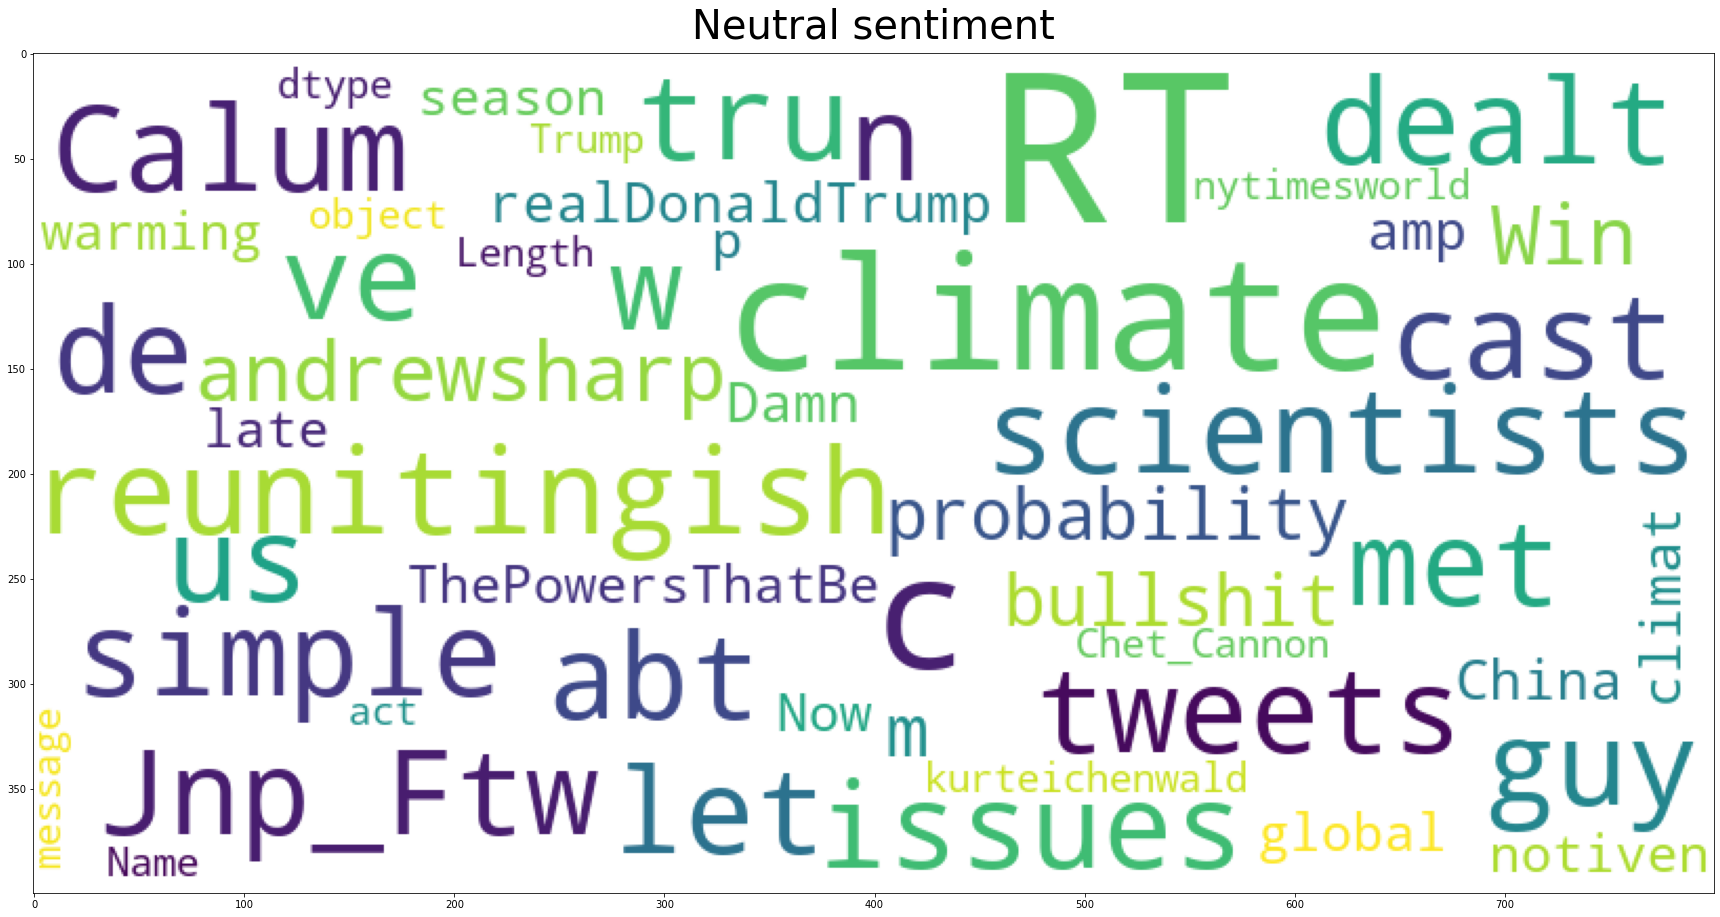

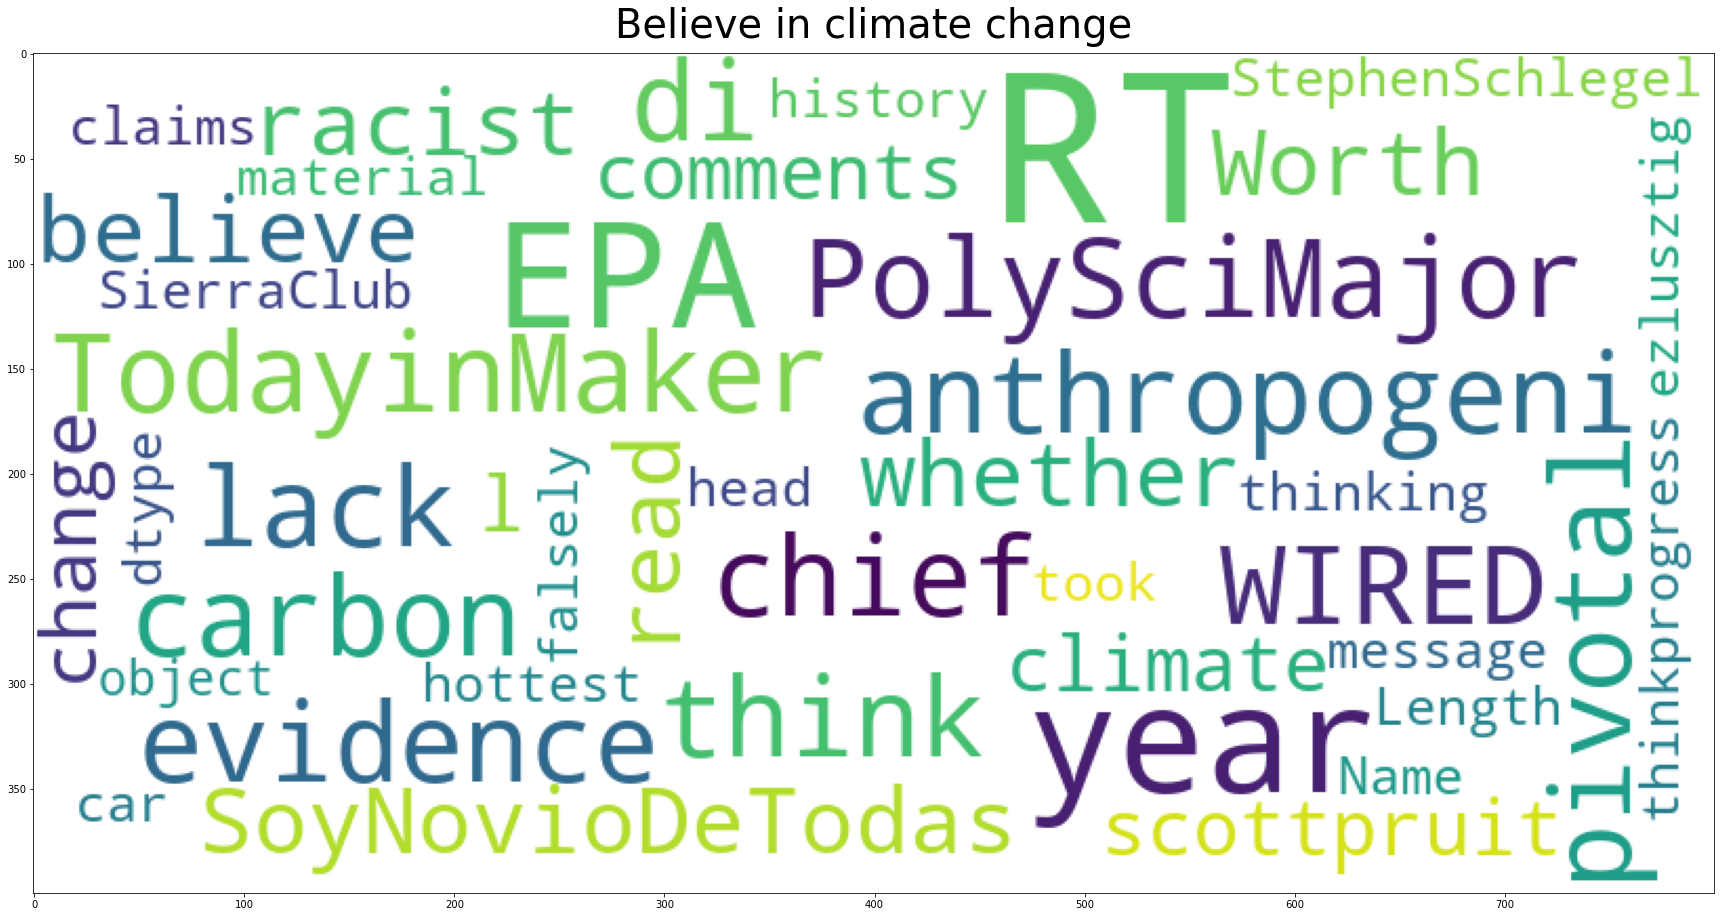

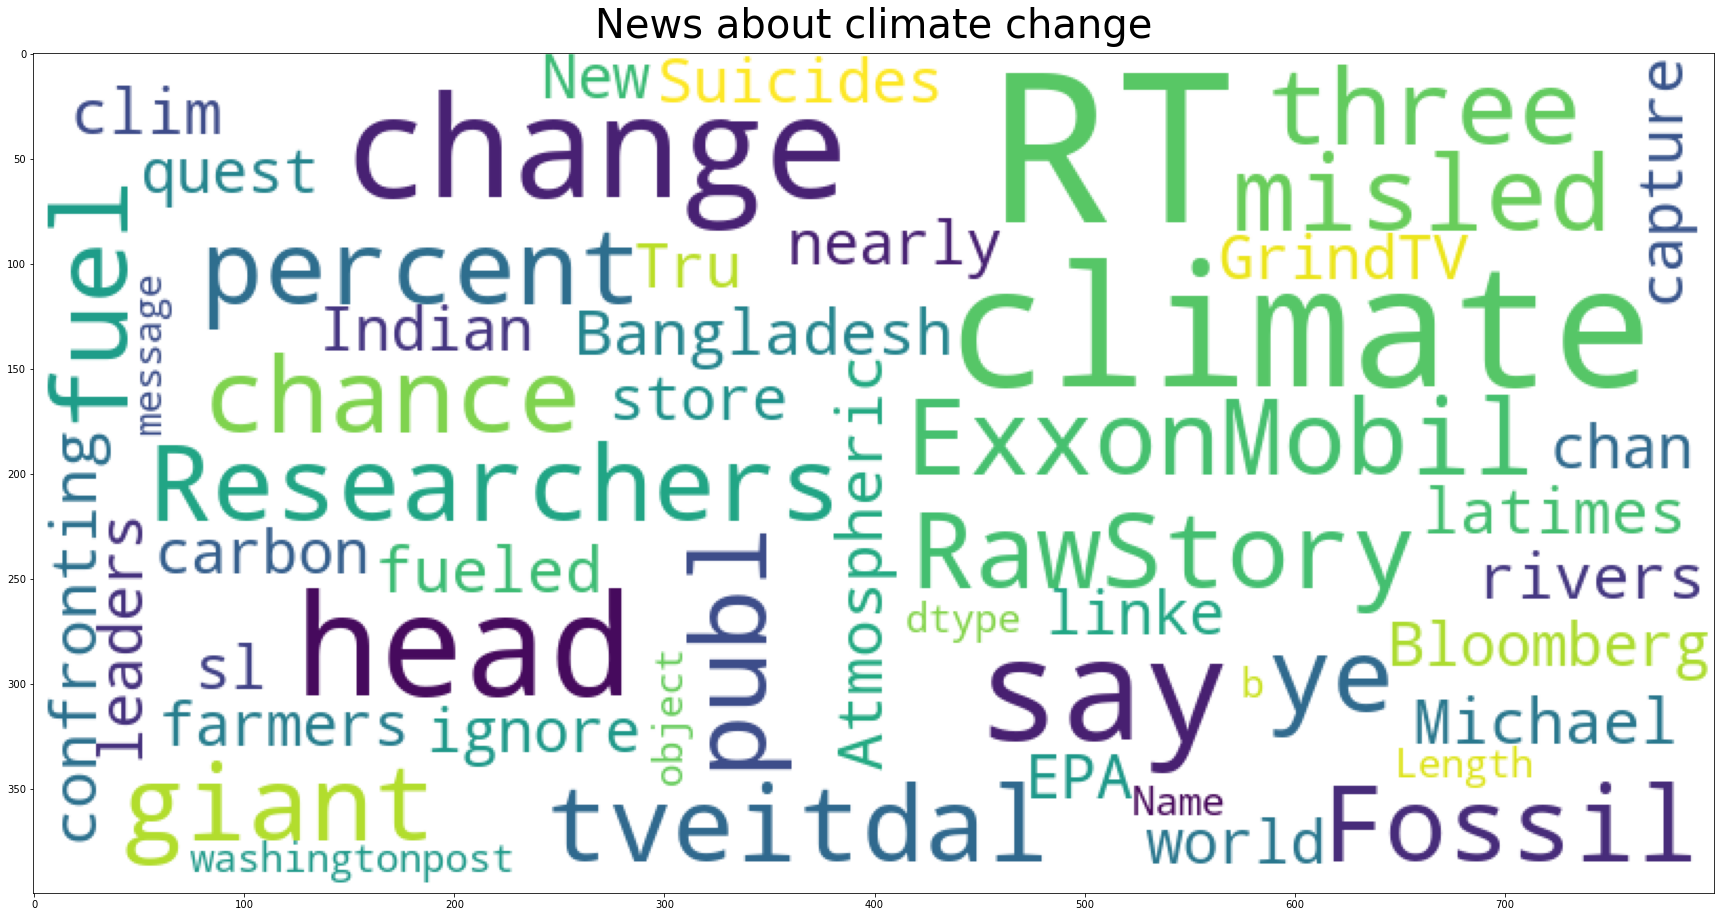

In [195]:
plot_word_cloud(train.loc[train.sentiment == -1]['message'], title="Don't believe in climate change")
plot_word_cloud(train.loc[train.sentiment == 0]['message'], title="Neutral sentiment")
plot_word_cloud(train.loc[train.sentiment == 1]['message'], title="Believe in climate change")
plot_word_cloud(train.loc[train.sentiment == 2]['message'], title="News about climate change")

In [196]:
#split X and y data for modelling
X = train['message']
y = train['sentiment']
testX = test['message']

#train_test_split on data for modelling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

## Modelling

In [197]:
# assign different classifiers to run through pipeline and choose best f1 score from:
classifiers = [
    LinearSVC(),
    LogisticRegression(n_jobs=-1),
    ExtraTreesClassifier(n_jobs=-1),
    RandomForestClassifier(n_jobs=-1),
    SVC(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(), 
]

# create a list from assigned models to iterate through and choose best model
names = ['Linear SVC', 'Logistic Regression', 'ExtraTreesClassifier','RandomForestClassifier', 'svc', 'AdaBoost', 'GradientBoostingClassifier', 'Nearest Neighbors', 'Decision Tree']


In [ ]:

#empty list to store all model scores and run times
results = []
#dictionary of model names and assigned models
models = {}
#dictionary of model name and model confusion matrix
confusion = {}
#classification report for all trained models
class_report = {}

#a for loop that trains different models and automatically scores their predictions for final model selection.
for name, clf in zip(names, classifiers):
    print('Fitting {:s} model...'.format(name))
    
    #pipeline iterating through all assigned models:
    pipeline = Pipeline([
        ('vect',CountVectorizer(analyzer=tweet_processing)),  # strings to tokens and then counts tokens on matrix.
        ('tfidf', TfidfTransformer()),  # counts vectorized tokens and weights classes.
        ('classifier', clf),
    ])
    #capture the run time of each model
    run_time = %timeit -q -o pipeline.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    
    print ('... scoring')
    f1        = f1_score(y_train, y_pred, average='macro')
    f1_test   = f1_score(y_test, y_pred_test, average='macro')
    
    #save results:
    models[name] = clf
    confusion[name] = confusion_matrix(y_train, y_pred)
    class_report[name] = classification_report(y_train, y_pred)
    
    results.append([name, f1_test, f1, run_time.best])
    
results = pd.DataFrame(results, columns=['Classifier','F1 Test', 'F1', 'Training Time'])
results.set_index('Classifier', inplace=True)
print ('... All done!')

Fitting Linear SVC model...
... predicting
... scoring
Fitting Logistic Regression model...
... predicting
... scoring
Fitting ExtraTreesClassifier model...
... predicting
... scoring
Fitting RandomForestClassifier model...
... predicting
... scoring
Fitting svc model...


In [ ]:
results.sort_values('F1 Test', ascending=False)

The Linear SVC model has very good performance on predicting the training data as well as the test data.

AttributeError: 'list' object has no attribute 'sort_values'

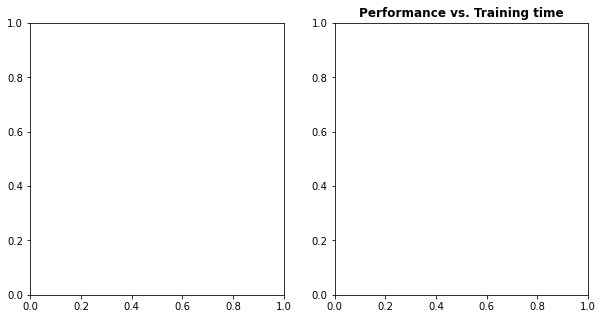

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.title('Performance vs. Training time',fontweight ="bold")
results.sort_values('F1', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.4,0.8])
results.plot(y='Training Time', kind='bar', ax=ax[1])

LinearSVC is by far the best choice if it comes to training time vs performance on test data.

In [58]:
#confusion matrix of best performing model
confusion['Linear SVC']

KeyError: 'Linear SVC'

In [170]:
#create the final Pipeline with pre-processing, weighing and modelling combined into a few lines of code.
best_pipe = Pipeline([
    ('vect',CountVectorizer(analyzer=tweet_processing)),  #tokenize the tweets
    ('tfidf', TfidfTransformer()), #weight the classes
    ('classifier', LinearSVC()),
])
best_pipe.fit(X,y)

Pipeline(steps=[('vect',
                 CountVectorizer(analyzer=<function tweet_processing at 0x0000024D87D020D0>)),
                ('tfidf', TfidfTransformer()), ('classifier', LinearSVC())])

In [171]:
#make predictions from from fitted model
y_pred = best_pipe.predict(testX)

In [172]:
#create test sentiment column from predictions
test['sentiment'] = y_pred.tolist()

#subset columns for output format
df_final_sub = test[['tweetid', 'sentiment']]

#view the final submission file
df_final_sub

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          2
10544   867455          0
10545   470892         -1

[10546 rows x 2 columns]

In [173]:
#Export prediction data to .csv for Kaggle submission
df_final_sub.to_csv('final_prediction.csv', index=False)